In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
import os
import relative_accuracy as ra
import geh as ga

In [3]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [4]:
import keras_tuner as kt
from keras_tuner import RandomSearch

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5_multi.npz")['x'] 
Output_train_5 = np.load("Deep_train_5_multi.npz")['y']

Deep_test_5   = np.load("Deep_test_5_multi.npz")['x'] 
Output_test_5 = np.load("Deep_test_5_multi.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15_multi.npz")['x'] 
Output_train_15 = np.load("Deep_train_15_multi.npz")['y']

Deep_test_15   = np.load("Deep_test_15_multi.npz")['x'] 
Output_test_15 = np.load("Deep_test_15_multi.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30_multi.npz")['x'] 
Output_train_30 = np.load("Deep_train_30_multi.npz")['y']

Deep_test_30   = np.load("Deep_test_30_multi.npz")['x'] 
Output_test_30 = np.load("Deep_test_30_multi.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60_multi.npz")['x'] 
Output_train_60 = np.load("Deep_train_60_multi.npz")['y']

Deep_test_60   = np.load("Deep_test_60_multi.npz")['x'] 
Output_test_60 = np.load("Deep_test_60_multi.npz")['y']

In [6]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

C:\Users\esugom\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [7]:
Test      = pd.read_csv('01test_scaled.csv', index_col=0, parse_dates=[8])

## Input

#### 5 mins

In [8]:
# Train
Xt5 = Deep_train_5
yt5 = scaler.inverse_transform(Output_train_5)
# Test
Xv5 = Deep_test_5
yv5 = scaler.inverse_transform(Output_test_5)

#### 15 mins

In [9]:
# Train
Xt15 = Deep_train_15
yt15 = scaler.inverse_transform(Output_train_15)
# Test
Xv15 = Deep_test_15
yv15 = scaler.inverse_transform(Output_test_15)

#### 30 mins

In [10]:
# Train
Xt30 = Deep_train_30
yt30 = scaler.inverse_transform(Output_train_30)
# Test
Xv30 = Deep_test_30
yv30 = scaler.inverse_transform(Output_test_30)

#### 60 mins

In [11]:
# Train
Xt60 = Deep_train_60
yt60 = scaler.inverse_transform(Output_train_60)
# Test
Xv60 = Deep_test_60
yv60 = scaler.inverse_transform(Output_test_60)

# LSTM Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
# We're using 7 features in our time series samples (7 spatial locations)
n_features = 7
length = 15
# val_percent = 0.12962        # 2 weeks
val_percent = 0.2        
batch_size = 32

In [14]:
input_shape = (length, n_features)

In [15]:
from tensorflow import keras

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [16]:
stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 5,
    restore_best_weights = True)

# 5 mins ahead

In [17]:
def build_model_5(hp):
    # define model
    model_5 = Sequential()
    
    # Simple LSTM layer
    model_5.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_5.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_5.add(Dense(n_features))
    
    model_5.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_5

In [18]:
tuner5 = RandomSearch(
    build_model_5,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=True,
    directory=os.path.normpath('C:/Runs'),
    project_name="6a-5"
)

In [19]:
tuner5.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [20]:
tuner5.search(Xt5, yt5, epochs=200,
           validation_split = val_percent,
           callbacks = [early_stop],
           verbose=2)

Trial 30 Complete [00h 21m 09s]
val_loss: 550.4823303222656

Best val_loss So Far: 519.3398132324219
Total elapsed time: 04h 52m 24s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner5.results_summary(1)

Results summary
Results in C:\Runs\6a-5
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 45
Units_2: 79
learning_rate: 0.001
Score: 519.3398132324219


### Best Model

In [22]:
best_hp5 = tuner5.get_best_hyperparameters()[0]
model5 = tuner5.hypermodel.build(best_hp5)

In [23]:
scaler_filename = "Best_HP/6a-5"
joblib.dump(best_hp5, scaler_filename) 

['Best_HP/6a-5']

In [24]:
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 45)            9540      
_________________________________________________________________
lstm_1 (LSTM)                (None, 79)                39500     
_________________________________________________________________
dense (Dense)                (None, 7)                 560       
Total params: 49,600
Trainable params: 49,600
Non-trainable params: 0
_________________________________________________________________


In [25]:
model5.fit(Xt5, yt5, 
          epochs = 100, 
          verbose = 0)

In [26]:
metrics5 = pd.DataFrame(model5.history.history)

<AxesSubplot:>

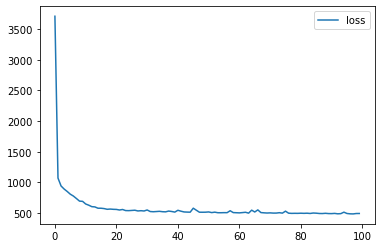

In [27]:
metrics5[['loss']].plot()

In [28]:
# model5 = keras.models.load_model("my_dir/6a-5")

# 15 mins ahead

In [31]:
def build_model_15(hp):
    # define model
    model_15 = Sequential()
    
    # 2 layer LSTM
    model_15.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_15.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_15.add(Dense(n_features))
    
    model_15.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_15

In [32]:
tuner15 = RandomSearch(
    build_model_15,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=True,
    directory=os.path.normpath('C:/Runs'),
    project_name="6a-15"
)

In [33]:
tuner15.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [34]:
tuner15.search(Xt15, yt15, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop], 
            verbose=2)

Trial 30 Complete [00h 10m 21s]
val_loss: 686.7027282714844

Best val_loss So Far: 683.2027893066406
Total elapsed time: 04h 18m 05s
INFO:tensorflow:Oracle triggered exit


In [35]:
tuner15.results_summary(1)

Results summary
Results in C:\Runs\6a-15
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 49
Units_2: 72
learning_rate: 0.001
Score: 683.2027893066406


### Best Model

In [36]:
best_hp15 = tuner15.get_best_hyperparameters()[0]
model15 = tuner15.hypermodel.build(best_hp15)

In [37]:
scaler_filename = "Best_HP/6a-15"
joblib.dump(best_hp15, scaler_filename) 

['Best_HP/6a-15']

In [38]:
model15.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 49)            11172     
_________________________________________________________________
lstm_1 (LSTM)                (None, 72)                35136     
_________________________________________________________________
dense (Dense)                (None, 7)                 511       
Total params: 46,819
Trainable params: 46,819
Non-trainable params: 0
_________________________________________________________________


In [39]:
model15.fit(Xt15, yt15, 
            epochs = 100,
            verbose = 0)

In [40]:
metrics15 = pd.DataFrame(model15.history.history)

<AxesSubplot:>

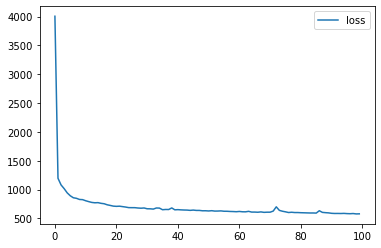

In [41]:
metrics15[['loss']].plot()

In [42]:
# model15 = keras.models.load_model("my_dir/6a-15")

# 30 mins ahead

In [45]:
def build_model_30(hp):
    # define model
    model_30 = Sequential()
    
    # 2 layer LSTM
    model_30.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_30.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_30.add(Dense(n_features))
    
    model_30.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_30

In [46]:
tuner30 = RandomSearch(
    build_model_30,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=True,
    directory=os.path.normpath('C:/Runs'),
    project_name="6a-30",
)

In [47]:
tuner30.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [48]:
tuner30.search(Xt30, yt30, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 30 Complete [00h 07m 21s]
val_loss: 907.5631408691406

Best val_loss So Far: 805.3597717285156
Total elapsed time: 03h 32m 51s
INFO:tensorflow:Oracle triggered exit


In [49]:
tuner30.results_summary(1)

Results summary
Results in C:\Runs\6a-30
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 93
Units_2: 83
learning_rate: 0.0001
Score: 805.3597717285156


### Best Model

In [50]:
best_hp30 = tuner30.get_best_hyperparameters()[0]
model30 = tuner30.hypermodel.build(best_hp30)

In [51]:
scaler_filename = "Best_HP/6a-30"
joblib.dump(best_hp30, scaler_filename) 

['Best_HP/6a-30']

In [52]:
model30.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 93)            37572     
_________________________________________________________________
lstm_1 (LSTM)                (None, 83)                58764     
_________________________________________________________________
dense (Dense)                (None, 7)                 588       
Total params: 96,924
Trainable params: 96,924
Non-trainable params: 0
_________________________________________________________________


In [53]:
model30.fit(Xt30, yt30, 
            epochs = 100,
            verbose = 0)

In [54]:
metrics30 = pd.DataFrame(model30.history.history)

<AxesSubplot:>

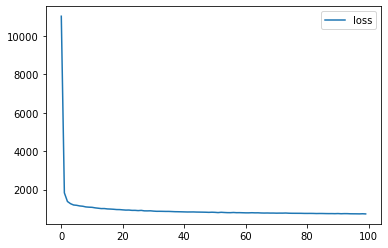

In [55]:
metrics30[['loss']].plot()

In [56]:
# model30 = keras.models.load_model("my_dir/6a-30")

# 60 mins ahead

In [59]:
def build_model_60(hp):
    # define model
    model_60 = Sequential()
    
    # 2 layer LSTM
    model_60.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_60.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_60.add(Dense(n_features))
    
    model_60.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_60

In [60]:
tuner60 = RandomSearch(
    build_model_60,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=2,
    overwrite=True,
    directory=os.path.normpath('C:/Runs'),
    project_name="6a-60",
)

In [61]:
tuner60.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [62]:
tuner60.search(Xt60, yt60, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 30 Complete [00h 09m 50s]
val_loss: 1035.51123046875

Best val_loss So Far: 981.9934387207031
Total elapsed time: 03h 40m 22s
INFO:tensorflow:Oracle triggered exit


In [63]:
tuner60.results_summary(1)

Results summary
Results in C:\Runs\6a-60
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 21
Units_2: 52
learning_rate: 0.01
Score: 981.9934387207031


### Best Model

In [64]:
best_hp60 = tuner60.get_best_hyperparameters()[0]
model60 = tuner60.hypermodel.build(best_hp60)

In [65]:
scaler_filename = "Best_HP/6a-60"
joblib.dump(best_hp60, scaler_filename) 

['Best_HP/6a-60']

In [66]:
model60.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 21)            2436      
_________________________________________________________________
lstm_1 (LSTM)                (None, 52)                15392     
_________________________________________________________________
dense (Dense)                (None, 7)                 371       
Total params: 18,199
Trainable params: 18,199
Non-trainable params: 0
_________________________________________________________________


In [67]:
model60.fit(Xt60, yt60, 
            epochs = 100,
            verbose = 0)

In [68]:
metrics60 = pd.DataFrame(model60.history.history)

<AxesSubplot:>

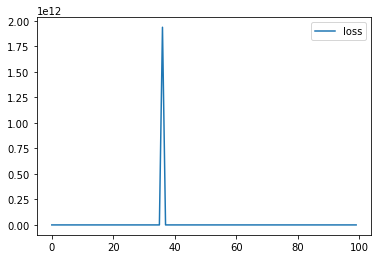

In [69]:
metrics60[['loss']].plot()

In [70]:
# model60 = keras.models.load_model("my_dir/6a-60")